In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
gauth = GoogleAuth()
gauth.CommandLineAuth()
drive = GoogleDrive(gauth)

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=198855760514-cttaak3avfg6568amn6d04dv7p7tfbdt.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code



Enter verification code:  4/1AX4XfWgHhrZKErf4nCmjddYaucjdyT8uNNZr9YAFcWcyXB_YkbZTjrpJzUA


Authentication successful.


In [3]:
class DataSeparator:
    """
    A class used to segment the dataset in different ways.

    ...

    Attributes
    ----------
    df_list : str
        a formatted string to determine subset of patients being analysed
        options: 
            - 'drugs': segment patients by those on single vs mult drugs
            - 'improved': segment patients by those who improved vs didn't
            - 'switched': segment patients by switches (L to E, E to L only)
            - 'all': segment by all of the above

    Methods
    -------
    get_df(self, drop_drug_na=False)
        Retrieves the specific dataset from the path.
        'drop_drug_na=True' will remove NAs and Brolucizumab from 'Drug' column.
    get_dataframes(self)
        Produces a list of dataframes based on df_list segmentation query.
    drug_df_separator(self)
        Segments the dataset by patients on single vs mult drugs.
    improved_df_separator(self)
        Segments the dataset by patients who improved vs didn't.
    switch_df_separator(self)
        Segments the dataset by patients who switched.
        Lucentis to Eylea, Eylea to Lucentis switches only.
    """
    
    def __init__(self, df_list):
        self.df_list = df_list
        
    def get_df(self, drop_drug_na=False):
        """
        Retrieves the specific dataset from the path.
        Input: Bool.
        Output: Pandas dataframe.
        """
        df = pd.read_csv('/home/jupyter/charliemacuject/pharma_reports/data/DME/devchau.csv')
        df.dropna(subset=['visual_acuity'], inplace=True)
        df.drop(columns=['Unnamed: 0'], inplace=True)
        df.rename(columns={'CreatedDate': 'admission_date', 'InjToday': 'Drug'}, inplace=True)
        df['admission_date'] = pd.to_datetime(df['admission_date'])
        if drop_drug_na:
            df = df.dropna(subset=['Drug'])
            df = df[df['Drug'] != 'nil']
            df = df[df['Drug'] != 'None']
            df = df[df['Drug'] != 'Brolucizumab']
        return df
    
    def get_dataframes(self):
        """
        Produces a list of dataframes based on df_list segmentation query.
        Input: self.
        Output: [Pandas dataframe].
        """
        if self.df_list == 'drugs':
            lucentis_df, eylea_df, mult_df = self.drug_df_separator()
            return [lucentis_df, eylea_df, mult_df]
        elif self.df_list == 'switched':
            luc_eyl, eyl_luc = self.switch_df_separator()
            luc_eyl
            return [luc_eyl, eyl_luc]
        elif self.df_list == 'improved':
            improved, not_improved, overall = self.improved_df_separator()
            return [improved, not_improved, overall]
        elif self.df_list == 'all':
            lucentis_df, eylea_df, mult_df = self.drug_df_separator()
            improved, not_improved, overall = self.improved_df_separator()
            luc_eyl, eyl_luc = self.switch_df_separator()
            return [lucentis_df, eylea_df, mult_df, improved, not_improved, overall, luc_eyl, eyl_luc]
        
    def drug_df_separator(self):
        """
        Produces a list of dataframes based single vs mult drugs.
        Input: self.
        Output: [Pandas dataframe].
        """
        df = self.get_df(drop_drug_na=True)
        df = df.dropna(subset=['Drug'])
        lucentis, eylea, avastin, mult = [], [], [], []
        drug_list = ['Lucentis', 'Eylea', 'Avastin']
        id_list = df['id'].unique()
        for eye in id_list:
            pdf = df[df['id'] == eye]
            drugs = pdf['Drug'].unique()
            if len(drugs) == 1:
                if drugs[0] == 'Lucentis':
                    lucentis.append(pdf)
                elif drugs[0] == 'Eylea':
                    eylea.append(pdf)
                else:
                    avastin.append(pdf)
            else:
                mult.append(pdf)
        return pd.concat(lucentis), pd.concat(eylea), pd.concat(mult)
    
    # groups dataframes by patients who improved vs didn't
        """
        Produces a list of dataframes based on improvement.
        Input: self.
        Output: [Pandas dataframe].
        """
    def improved_df_separator(self):
        df = self.get_df()
        improved, not_improved = [], []
        id_list = df['id'].unique()
        for eye in id_list:
            pdf = df[df['id'] == eye]
            pdf.dropna(subset=['visual_acuity'], inplace=True)
            pdf.sort_values(by=['admission_date'], inplace=True)
            vision = pdf['visual_acuity'].to_list()
            if max(vision) == vision[0]:
                not_improved.append(pdf)
            else:
                improved.append(pdf)
        return pd.concat(improved), pd.concat(not_improved), df
    
    def switch_df_separator(self):
        """
        Produces a list of dataframes based on switches.
        Input: self.
        Output: [Pandas dataframe].
        """
        df = self.get_df(drop_drug_na=True)
        df = df[df['Drug'] != 'Avastin']
        luc_eyl, eyl_luc = [], []
        drug_list = ['Lucentis', 'Eylea']
        id_list = df['id'].unique()
        for eye in id_list:
            pdf = df[df['id'] == eye]
            drugs = pdf['Drug'].unique()
            if len(drugs) > 1:
                if drugs[0] == 'Lucentis' and drugs[1] == 'Eylea':
                    luc_eyl.append(pdf)
                elif drugs[0] == 'Eylea' and drugs[1] == 'Lucentis':
                    eyl_luc.append(pdf)
            else:
                pass
        return pd.concat(luc_eyl), pd.concat(eyl_luc)

In [6]:
dataframe = DataSeparator('all')
df_list = dataframe.get_dataframes()

In [7]:
df_list[7].head()

,Unnamed: 0.1,id,admission_date,Laterality,visual_acuity,Drug,InjNext,NextInt
48,66,20318,2020-11-06,Left,46.0,Eylea,Eylea,4.0
54,72,20318,2018-05-22,Right,65.0,Lucentis,Eylea,4.0
55,73,20318,2018-06-19,Right,65.0,Eylea,Eylea,4.0
57,75,20318,2018-07-17,Right,65.0,Eylea,Eylea,4.0
64,82,20318,2020-11-06,Right,61.0,Eylea,Eylea,4.0


In [4]:
class InitialMetrics(DataSeparator):
    
    def __init__(self, df_list):
        self.df_list = df_list
    
    def study_period(self, df):
        """
        Returns the study period in question.
        Input: Pandas dataframe.
        Output: datetime object x 2.
        """
        dates = df['admission_date']
        return dates.min(), dates.max()
    
    def num_patients(self, df):
        """
        Returns the number of patients treated.
        """
        return len(df['id'].unique())
    
    def total_visits(self, df):
        """
        Returns the number of total visits.
        """
        return len(df)
    
    def initiation_drug(self, df):
        '''
        Input: Pandas dataframe of all patients.
        Output: mean initiation drugs.
        '''
        id_list = df['id'].unique()
        lst, names = [], ['Lucentis', 'Eylea', 'Avastin']
        for eye in id_list:
            pdf = df[df['id'] == eye]
            pdf.sort_values(by=['admission_date'], inplace=True)
            pdf.dropna(subset=['Drug'], inplace=True)
            df = df[df['Drug'] != 'nil']
            df = df[df['Drug'] != 'None']
            if len(pdf['Drug']) != 0 and pdf['Drug'].iloc[0] in names:
                lst.append(pdf['Drug'].iloc[0])
        luc_int = np.round(lst.count('Lucentis') / len(lst), 3)
        eyl_int = np.round(lst.count('Eylea') / len(lst), 3)
        av_int = np.round(lst.count('Avastin') / len(lst), 3)
        return luc_int, eyl_int, av_int
    
            
    def results_table(self):
        """
        Returns a dataframe of results for all initial metrics.
        Input: self.
        Output: Pandas dataframe.
        """
        df = DataSeparator.get_df(self)
        earliest, latest = self.study_period(df)
        luc_int, eyl_int, av_int = self.initiation_drug(df)
        dict = {'Start': earliest, 'End': latest, 'Num_Patients': self.num_patients(df),
               'TotalVisits': self.total_visits(df), 'LucentisInit%': luc_int*100, 'EyleaInit%': eyl_int*100, 
                'AvastinInit%': av_int*100} 
        return pd.DataFrame(dict, index=[0])
    
    def upload_results_table(self):
        dataframe = self.results_table()
        dataframe.to_csv('/home/jupyter/charliemacuject/pharma_reports/initialmetrics.csv')
        

In [17]:
class Utilisation(DataSeparator):
    
    def get_df(self): return DataSeparator.get_df(self)
    
    def drug_totals(self, num_visits, drug_name):
        df = self.get_df()
        eye_list = df['id'].unique()
        drugs_list, names_list = [], ['Lucentis', 'Avastin', 'Eylea']
        for eye in eye_list:
            count, df_new = 0, df[df['id'] == eye]
            if len(df_new) > num_visits:
                for i in range(len(df_new)):
                    while count < num_visits:
                        date = df_new['admission_date'].iloc[i]
                        drug = df_new['Drug'].iloc[i]
                        if drug in names_list:
                            drugs_list.append(drug)
                        count += 1
                        i += 1
        length = len(drugs_list)
        count_drug = drugs_list.count(drug_name)
        return count_drug

    # this function recurses over all patients in dataframe
    def all_drugs(self, visit_num, drug_name):
        df = self.get_df()
        counts = []
        for i in range(1, visit_num+1):
            average_drug = self.drug_totals(i, drug_name)
            counts.append(average_drug)
        return counts
    
    # plot the figures
    def plot_ut(self):
        w, y, z = self.all_drugs(100, 'Lucentis'), self.all_drugs(100, 'Eylea'), self.all_drugs(100, 'Avastin')
        matplotlib.rcParams['font.size'] = 18
        x = list(range(1, 101))
        fig = plt.figure(figsize=(12, 7))
        ax = plt.axes()
        ax.set(xlabel='Visit Number', ylabel='Number of Injections Using Drug')
        ax.plot(x, w, label='Lucentis', color='#03254c')
        ax.plot(x, y, label='Eylea', color='#187bcd')
        ax.plot(x, z, label='Avastin', color='orange')
        ax.legend(loc='lower left')
        right_side = ax.spines["right"]
        left_side = ax.spines['left']
        top_side = ax.spines['top']
        right_side.set_visible(False)
        left_side.set_visible(False)
        top_side.set_visible(False)

In [13]:
df = pd.read_csv('/home/jupyter/charliemacuject/pharma_reports/data/DME/devchau.csv')

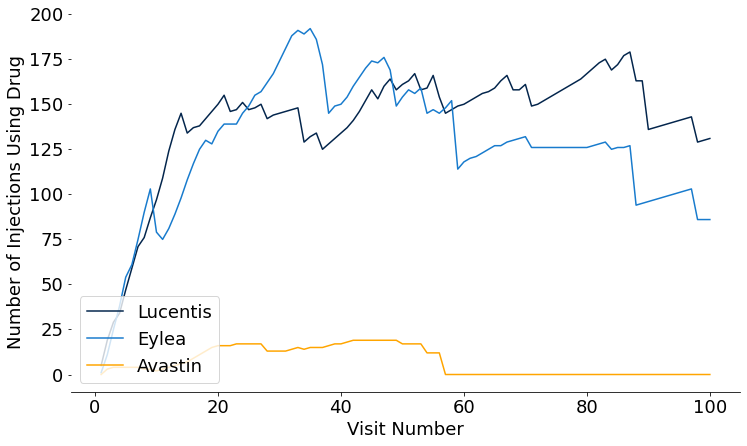

In [18]:
plot = Utilisation('all')
plot.plot_ut()

In [9]:
table = InitialMetrics('all')
table.upload_results_table()

In [21]:
class Interval(DataSeparator):
    
    def get_df_list(self): return DataSeparator.get_dataframes(self)
    
    def interval_column(self, pdf):
        '''
        Input: patient dataframe.
        Output: patient dataframe with additional column for interval length.
        '''
        pdf.dropna(subset=['admission_date'], inplace=True)
        pdf['admission_date'] = pd.to_datetime(pdf['admission_date'])
        pdf = pdf.sort_values(by=['admission_date'])
        dates = pdf['admission_date'].reset_index(drop=True)
        weeks = [0]
        for i in range(len(dates)-1):
            week = int((dates[i+1] - dates[i]).days / 7)
            weeks.append(week)
        pdf['Interval'] = weeks
        return pdf.reset_index(drop=True)

    def interval_all(self):
        '''
        Input: whole dataframe.
        Output: whole dataframe with additional column for interval length.
        '''
        df_list = self.get_df_list()
        new_list = []
        for df in df_list:
            id_list = df['id'].unique()
            frames = []
            for eye in id_list:
                pdf = df[df['id'] == eye]
                pdf = self.interval_column(pdf)
                frames.append(pdf)
            new_list.append(pd.concat(frames))
        return new_list
    
    def mean_intervals(self):
        df_list = self.interval_all()
        mean_list, std_list = [], []
        for df in df_list:
            int_list = df.Interval.to_list()
            int_list = [x for x in int_list if x > 0 and x < 20]
            mean_list.append(np.mean(int_list))
            std_list.append(np.std(int_list))
        return mean_list, std_list
    
    def results_table(self):
        """
        Returns a dataframe of results..
        Input: self.
        Output: Pandas dataframe.
        """
        names = ['Lucentis', 'Eylea', 'Multiple']
        mean_list, std_list = self.mean_intervals()
        dict = {'Drug': names, 'mean_int': mean_list, 'mean_std': std_list} 
        df = pd.DataFrame(dict)
        df.set_index('Drug', inplace=True)
        return df
    
    def upload_results_table(self):
        dataframe = self.results_table()
        dataframe.to_csv('/home/jupyter/charliemacuject/pharma_reports/int_metrics.csv')

In [22]:
table = Interval('drugs')
table.upload_results_table()

In [44]:
class Vision(DataSeparator):
    """
    A class used to produce common visual metrics.

    ...

    Attributes
    ----------
    df_list : str
        a formatted string to determine subset of patients being analysed
        options: 
            - 'drugs': segment patients by those on single vs mult drugs
            - 'improved': segment patients by those who improved vs didn't
            - 'switched': segment patients by switches (L to E, E to L only)
            - 'all': segment by all of the above

    Methods
    -------
    pvi(self, dataset)
        Produces a list of patient PVIs from dataset.
    tpvi(self, dataset)
        Produces a list of patient TPVIs from dataset.
    vlp(self, dataset)
        Produces a list of patient VLPs from dataset.
    ovc(self, dataset)
        Produces a list of patient OVCs from dataset.
    vision_weeks(self, weeks)
        Calculates the mean vision for all patients at a specific visit number.
    anchor(self, weeks)
        Produces a dataframe of mean vision over the first year, including trial results.
    list_results(self, dataset)
        Produces a list of above visual metrics (PVI, TPVI, VLP, OVC) for given dataset.
    list_sds(self, dataset)
        Produces a list of the 95% CI bounds for all visual metrics, for given dataset.
    print_results(self)
        Displays results for all visual metrics.
    results_table(self)
        Returns a Pandas dataframe of all visual metrics.
    """
    
    # df_list can be either drugs, improved, switched or all
    def __init__(self, df_list):
        self.df_list = df_list
    
    def pvi(self, df):
        """
        Produces a list of patient PVIs from dataset.
        Peak Visual Improvement (PVI) is defined as max vision minus initial vision.
        Input: Pandas dataframe.
        Output: list of LogMAR letters.
        """
        id_list = df['id'].unique()
        pvi_list = []
        for eye in id_list:
            pdf = df[df['id'] == eye]
            pdf.sort_values(by=['admission_date'], inplace=True)
            visions = pdf['visual_acuity'].to_list()
            if len(visions) > 0:
                pvi_pdf = max(visions) - visions[0]
                pvi_list.append(pvi_pdf)
        return pvi_list
    
    def tpvi(self, df):
        """
        Produces a list of patient TPVIs from dataset.
        Time to Peak Visual Improvement (TPVI) is defined in days.
        Input: Pandas dataframe.
        Output: list of days.
        """
        id_list = df['id'].unique()
        tpvi_list = []
        for eye in id_list:
            pdf = df[df['id'] == eye]
            pdf.sort_values(by=['admission_date'], inplace=True)
            dates = pdf['admission_date'].to_list()
            initial_date = dates[0]
            pdf.dropna(subset=['visual_acuity'], inplace=True)
            visions = pdf['visual_acuity'].to_list()
            ndf = pdf[pdf['visual_acuity'] == max(visions)]
            new_dates = ndf['admission_date'].to_list()
            time = (new_dates[0] - initial_date).days
            tpvi_list.append(time)
        return tpvi_list
    
    def ovc(self, df):
        """
        Produces a list of patient OVCs from dataset.
        Overall Visual Change (OVC) is defined as last vision minus initial vision.
        Input: Pandas dataframe.
        Output: list of LogMAR letters.
        """
        id_list = df['id'].unique()
        ovc_list = []
        for eye in id_list:
            pdf = df[df['id'] == eye]
            pdf.sort_values(by=['admission_date'], inplace=True)
            pdf.dropna(subset=['visual_acuity'], inplace=True)
            visions = pdf['visual_acuity'].to_list()
            ovc_list.append(visions[-1] - visions[0])
        return ovc_list
    
    def vlp(self, df):
        """
        Produces a list of patient VLPs from dataset.
        Vision Loss from Peak (VLP) is defined as max vision minus last vision.
        Input: Pandas dataframe.
        Output: list of LogMAR letters.
        """
        id_list = df['id'].unique()
        vlp_list = []
        for eye in id_list:
            pdf = df[df['id'] == eye]
            pdf.sort_values(by=['admission_date'], inplace=True)
            pdf.dropna(subset=['visual_acuity'], inplace=True)
            visions = pdf['visual_acuity'].to_list()
            recent = visions[-1]
            max_vision = max(visions)
            vlp_list.append(max_vision - recent)
        return vlp_list
    
    def vision_weeks(self, weeks):
        """
        Produces average vision at a certain visit after initiation.
        Input: dataframe, number of visits after initiation (int)
        Output: mean visual acuity of all patients at that visit
        """
        df = DataSeparator.get_df(self)
        id_list = df['id'].unique()
        df.dropna(subset=['visual_acuity'], inplace=True)
        lst = []
        for eye in id_list:
            pdf = df[df['id'] == eye]
            pdf.sort_values(by=['admission_date'], inplace=True)
            visions = pdf['visual_acuity'].to_list()
            if len(visions) > (weeks + 1):
                initial = visions[0]
                current = visions[weeks]
                lst.append(current - initial)
        return np.round(np.mean(lst), 2)
    
    def list_results(self, df):
        """
        Produces a list of the visual metrics defined (PVI, TPVI, VLP, OVC).
        Input: Pandas dataframe.
        Output: float x 4.
        """
        pvi_list, tpvi_list, vlp_list, ovc_list = self.pvi(df), self.tpvi(df), self.vlp(df), self.ovc(df)
        return np.mean(pvi_list), np.mean(tpvi_list), np.mean(vlp_list), np.mean(ovc_list)
    
    def list_sds(self, df):
        """
        Produces a list of the 95% CI bounds for all visual metrics.
        Input: Pandas dataframe.
        Output: float x 4
        """
        pvi_list, tpvi_list, vlp_list, ovc_list = self.pvi(df), self.tpvi(df), self.vlp(df), self.ovc(df)
        lst = [pvi_list, tpvi_list, vlp_list, ovc_list]
        to_return = []
        for item in lst:
            ci = stats.t.interval(alpha=0.95, df=len(item)-1, loc=np.mean(item), scale=stats.sem(item))
            std = np.mean(item) - ci[0]
            to_return.append(std)
        return np.round(to_return[0], 2), np.round(to_return[1], 2), np.round(to_return[2], 2), np.round(to_return[3], 2)
    
    def mean_vis(self, df):
        id_list = df['id'].unique()
        mean_list = []
        for eye in id_list:
            pdf = df[df['id'] == eye]
            pdf.sort_values(by=['admission_date'], inplace=True)
            pdf.dropna(subset=['visual_acuity'], inplace=True)
            visions = pdf['visual_acuity'].to_list()
            mean_list.append(np.mean(visions))
        return mean_list
    
    def std_vis(self, df):
        id_list = df['id'].unique()
        std_list = []
        for eye in id_list:
            pdf = df[df['id'] == eye]
            pdf.sort_values(by=['admission_date'], inplace=True)
            pdf.dropna(subset=['visual_acuity'], inplace=True)
            visions = pdf['visual_acuity'].to_list()
            std_list.append(np.std(visions))
        return std_list

    def print_results(self):
        """
        Displays the results for all visual metrics.
        Input: self.
        Output: float x 4
        """
        dfs = DataSeparator.get_dataframes(self)
        lst = []
        if self.df_list == 'drugs':
            print("Displaying results for Lucentis, Eylea, and Multiple Drugs.")
        elif self.df_list == 'improved':
            print("Displaying results for Improved, Not_Improved and Overall.")
        elif self.df_list == 'switched':
            print("Displaying results for patients who switched from Lucentis to Eylea, and Eylea to Lucentis.")
        else:
            print("Displaying results for Lucentis, Eylea, Multiple Drugs, Improved, Didn't Improve, Lucentis to Eylea, Eylea to Lucentis.")
        for dataframe in dfs:
            pvi, tpvi, vlp, ovc = self.list_results(dataframe)
            pvi_sd, tpvi_sd, vlp_sd, ovc_sd = self.list_sds(dataframe)
            print("  ")
            print("PVI = {} letters, CI = +/-{}".format(np.round(pvi, 2), pvi_sd))
            print("TPVI = {} days, CI = +/-{}".format(np.round(tpvi), tpvi_sd))
            print("VLP = {} letters, CI = +/-{}".format(np.round(vlp, 2), vlp_sd))
            print("OVC = {} letters, CI = +/-{}".format(np.round(ovc, 2), ovc_sd))
            print("  ")
            
    def results_table(self):
        """
        Returns a dataframe of results for all visual metrics.
        Input: self.
        Output: Pandas dataframe.
        """
        names = ['Lucentis', 'Eylea', 'Multiple', 'Improved', 'Not_Improved', 'Overall', 'Luc_to_Eyl', 'Eyl_to_Luc']
        df_lst = DataSeparator.get_dataframes(self)
        pvi, tpvi, vlp, ovc, pvi_sd, tpvi_sd, vlp_sd, ovc_sd, mean_vis, vis_std = [], [], [], [], [], [], [], [], [], []
        for i in range(len(df_lst)):
            dataframe = df_lst[i]
            name = names[i]
            Pvi, Tpvi, Vlp, Ovc = self.list_results(dataframe)
            Pvi_sd, Tpvi_sd, Vlp_sd, Ovc_sd = self.list_sds(dataframe)
            mean_vision = np.mean(self.mean_vis(dataframe))
            vision_std = np.mean(self.std_vis(dataframe))
            pvi.append(Pvi), tpvi.append(Tpvi), vlp.append(Vlp), ovc.append(Ovc)
            pvi_sd.append(Pvi_sd), tpvi_sd.append(Tpvi_sd), vlp_sd.append(Vlp_sd), ovc_sd.append(Ovc_sd)
            mean_vis.append(mean_vision), vis_std.append(vision_std)
        dict = {'Drug': names, 'PVI': pvi, 'PVI_sd': pvi_sd, 'TPVI': tpvi, 'TPVI_sd': tpvi_sd,
                'VLP': vlp, 'VLP_sd': vlp_sd, 'OVC': ovc, 'OVC_sd': ovc_sd, 'MeanVis': mean_vis, 'StdVis': vis_std} 
        df = pd.DataFrame(dict)
        df.set_index('Drug', inplace=True)
        return df
    
    def upload_results_table(self):
        dataframe = self.results_table()
        dataframe.to_csv('/home/jupyter/charliemacuject/pharma_reports/visual_metrics.csv')
        
    def patient_counts(self):
        df_list = DataSeparator.get_dataframes(self)
        counts = []
        for df in df_list:
            counts.append(len(df.id.unique()))
        return counts

In [36]:
upload = Vision('all')
upload.results_table()

,PVI,PVI_sd,TPVI,TPVI_sd,VLP,VLP_sd,OVC,OVC_sd,MeanVis,StdVis
Drug,,,,,,,,,,
Lucentis,5.263158,3.68,99.052632,76.22,3.894737,3.41,1.368421,3.69,74.524615,3.103612
Eylea,5.928571,3.61,148.785714,95.25,4.857143,3.46,1.071429,5.32,65.681521,5.129477
Multiple,8.852941,3.03,298.735294,156.96,9.735294,3.79,-0.882353,4.42,71.913342,6.940178
Improved,14.092593,3.25,496.129630,144.64,10.518519,3.13,3.574074,4.15,70.973408,7.528411
Not_Improved,0.000000,NaN,0.000000,NaN,7.350000,4.30,-7.350000,4.30,74.554635,4.341878
Overall,10.283784,2.77,362.040541,116.55,9.662162,2.53,0.621622,3.38,71.941308,6.667186
Luc_to_Eyl,6.700000,4.67,340.000000,377.98,9.300000,8.38,-2.600000,6.71,70.081506,6.575734
Eyl_to_Luc,0.000000,NaN,0.000000,NaN,4.000000,NaN,-4.000000,NaN,60.400000,7.364781


In [48]:
class Switches(DataSeparator):
    
    def switches(self):
        df = DataSeparator.get_df(self, drop_drug_na=True)
        id_list = df['id'].unique()
        switch_list = []
        for eye in id_list:
            pdf = df[df['id'] == eye]
            switch_count = 0
            for i in range(len(pdf)-1):
                if pdf['Drug'].iloc[i] != pdf['Drug'].iloc[i+1]:
                    switch_count += 1
            switch_list.append(switch_count)
        return np.mean(switch_list), np.median(switch_list), np.std(switch_list), min(switch_list), max(switch_list)

In [49]:
switch = Switches('all')
switch.switches()

(1.8169014084507042, 0.0, 3.100703505612287, 0, 15)

In [28]:
class Upload:
    """
    A class used to upload the required dataframes to Google Drive.

    ...

    Attributes
    ----------
    folder : str
        a formatted string to determine the folder to upload to
        options: 'pharma_reports', 'research'
    dr_name : str
        a formatted string of audited doctor, used to create folder in drive
    file_list : list
        a list of files to upload to Drive

    Methods
    -------
    set_folder(self)
        Determines the path ID of the folder to upload to.
    view_files(self)
        View all folders and file in the Google Drive.
    create_folder(self)
        Create folder on Google Drive.
    upload_files(self)
        Upload the specified file of the object.
    """
    
    def __init__(self, folder, dr_name, file_list):
        self.folder = folder
        self.dr_name = dr_name
        self.file_list = file_list
        
    def retrieve_files(self):
        """
        Returns a list of files in the main directory to upload.
        """
        if self.file_list == 'all':
            return ['initialmetrics.csv','int_metrics.csv', 'visual_metrics.csv']
        
    def set_folder(self):
        """
        Determines the path ID of the folder to upload to.
        Input: self.
        Output: folder_id (PyDrive object)
        """
        if self.folder == 'pharma_reports':
            folder_id = '1tzvQ-xBZOy6_zA5EPbnQ5nEDENurAj1N'
        elif self.folder == 'research':
            folder_id = '1GuUeRc7Zqe5GdM1dmJOUF6VPW5NklH-R'
        else:
            folder_id = '1INvWwtJhtiD4vqCEpehd4RT06I1-50pU'
        return folder_id
    
    def view_files(self):
        """
        View all folders and file in the Google Drive.
        """
        fileList = drive.ListFile({'q': "'root' in parents and trashed=false"}).GetList()
        for file in fileList:
            print('Title: %s, ID: %s' % (file['title'], file['id']))
            
    def create_folder(self):
        """ 
        Create folder on Google Drive.
        """
        folder_name, parent_folder_id = self.dr_name, self.set_folder()
        folder_metadata = {'title': folder_name,
                           # Define the file type as folder
                           'mimeType': 'application/vnd.google-apps.folder',
                           # ID of the parent folder        
                           'parents': [{"kind": "drive#fileLink", "id": parent_folder_id}]}
        folder = drive.CreateFile(folder_metadata)
        folder.Upload()
        # Return folder informations
        return folder['id']
                
    def upload_files(self):
        """
        Upload the specified file of the object.
        """
        folder_id = self.create_folder()
        upload_file_list = self.retrieve_files()
        for upload_file in upload_file_list:
            gfile = drive.CreateFile({'parents': [{'id': folder_id}]})
            # Read file and set it as the content of this instance.
            gfile.SetContentFile(upload_file)
            gfile.Upload() # Upload the file.

In [37]:
def generate_audit(dr_name, folder='pharma_reports', file_list='all', df_list='all'):
    initialmetrics = InitialMetrics(df_list)
    initialmetrics.upload_results_table()
    int_metrics = Interval('drugs')
    int_metrics.upload_results_table()
    visual_metrics = Vision(df_list)
    visual_metrics.upload_results_table()
    to_upload = Upload(folder, dr_name, file_list)
    to_upload.upload_files()

In [38]:
generate_audit('DevinderChauhan')

In [21]:
df = pd.read_csv('/home/jupyter/charliemacuject/pharma_reports/data/DME/devchau.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,id,CreatedDate,Laterality,visual_acuity,InjToday,InjNext,NextInt
0,0,0,19913,22/02/2017,Left,76.0,NaN,NaN,NaN
1,1,1,19913,09/03/2017,Left,76.0,Avastin,NaN,NaN
2,2,2,19913,22/03/2017,Left,76.0,NaN,NaN,NaN
3,3,3,19913,11/04/2017,Left,76.0,Lucentis,Lucentis,4.0
4,4,4,19913,09/05/2017,Left,76.0,Lucentis,Lucentis,4.0
